# HSE-2024 text classification project

## Table of content
* [Imports](#c1)
* [Data loading and preprocessing](#c2)
* [Custom dataset](#c3)
* [Custom model](#c4)
* [Trainer](#c5)
* [Model training](#c6)

### Imports <a class="anchor" id="c1"></a>

In [1]:
import numpy as np
import pandas as pd

import torch
from sklearn.model_selection import train_test_split

import os
import re
import string

from classes import Preprocessor, MyModel, Trainer

### Data loading and preprocessing <a class="anchor" id="c2"></a>

In [2]:
RANDOM_STATE = 42
torch.manual_seed(RANDOM_STATE)

In [3]:
base_dir = 'data/'
if not os.path.exists(base_dir):  # создадим папку, куда будем сохранять модели, и где будут лежать данные
    os.makedirs(base_dir)

In [4]:
texts = pd.read_csv(f'{base_dir}texts_and_metadata.txt', sep='\t')
texts.sample(3)

,document.id,source,stage,source_text,lemm_text,city,region,date
5626,416407329,iqbuzz,3,"Юля, и как можно считать Россию агрессором??? ...",юля можно считать россия агрессор абхазец сей ...,Москва,Москва,2014-03-24
1064,381729903,iqbuzz,2,"Понятно. А у меня мама из Одессы, а папа - кра...",re народ действительно просить понятно мама од...,Ейск,Краснодарский край,2014-02-25
10426,894866145,iqbuzz,3,"Олгерд, во во только срать и умеете,большего н...",олгерд срать русский тот монгол молча ум праде...,Строитель,Иркутская область,2015-05-12


In [5]:
data = pd.read_csv(f'{base_dir}coding_results.txt', low_memory=False, sep='\t')
data.sample(3)

,document.id,source,stage,data,assessor,seed_eth_group,for_questions_about_text,do_text_make_sense_raw,do_text_make_sense_recoded,has_ethnonym_raw,...,represent_ethicity_raw,represent_ethicity_meaning,is_ethicity_superior_raw,is_ethicity_superior_meaning,is_ethicity_aggressor_raw,is_ethicity_aggressor_meaning,is_ethicity_dangerous_raw,is_ethicity_dangerous_meaning,comment,old_id
68635,706045823,iqbuzz,2,2016-10-03 14:27:02,adzhigitova,малорос,1,yes,1,several,...,1.0,no,3.0,irrel,2.0,agressor,2.0,yes,NaN,малоросс_74
30758,830652798,iqbuzz,3,2017-04-04 09:52:16,belchonok,вайнах,1,yes,1,several,...,1.0,no,3.0,irrel,3.0,irrel,1.0,no,NaN,830652798
45548,978410449,iqbuzz,3,2017-04-04 15:27:19,skuchilina,удмурт,0,yes,1,several,...,1.0,no,3.0,irrel,3.0,irrel,1.0,no,NaN,978410449


In [6]:
df = texts.merge(data, how='left')
df.sample(5)

,document.id,source,stage,source_text,lemm_text,city,region,date,data,assessor,...,represent_ethicity_raw,represent_ethicity_meaning,is_ethicity_superior_raw,is_ethicity_superior_meaning,is_ethicity_aggressor_raw,is_ethicity_aggressor_meaning,is_ethicity_dangerous_raw,is_ethicity_dangerous_meaning,comment,old_id
29437,792121012,iqbuzz,2,"Ренат, заявления по поводу почти поголовного (...",ренат заявление повод почти поголовный более я...,Великий Новгород,Новгородская область,2015-03-05,2016-09-26 15:49:27,skuchilina,...,1.0,no,3.0,irrel,1.0,victim,1.0,no,NaN,черкес_86
27656,404082970,iqbuzz,2,"Γеннадий, насчет <b>уйгуров</b> я знаю( и что ...",насчёт уйгур знать китаец враг ислам знать сир...,Назрань,Ингушетия,2014-03-14,2016-10-03 02:56:22,skuchilina,...,1.0,no,3.0,irrel,3.0,irrel,3.0,irrel,NaN,уйгур_15
26671,800495849,iqbuzz,2,Факультет удмуртской филологии - единственная ...,факультет удмуртский филология единственный ро...,Москва,Москва,2014-11-20,2016-09-30 12:58:12,alyonam,...,3.0,yes,3.0,irrel,1.0,victim,1.0,no,NaN,удмуртский_10
29698,874076275,iqbuzz,2,Куда не плюнь везде <b>черномазые</b>: в клипа...,куда плюнуть везде черномазый клип сериал прог...,Санкт-Петербург,Санкт-Петербург,2015-04-25,2016-10-04 16:33:29,an_men,...,3.0,yes,2.0,high,3.0,irrel,1.0,no,NaN,черножопый_135
59306,854008627,iqbuzz,3,"[[id141789868|Игорь], )))))))))))) да не пойме...",игорь понять русский еврей некоторый этот поня...,Москва,Москва,2015-04-10,2017-04-05 17:54:08,DariaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"русский, еврей, немец, англичанин, француз, ук...",854008627


In [7]:
df.shape

(84784, 61)

In [8]:
df['do_text_make_sense_raw'].value_counts()

do_text_make_sense_raw
yes     78372
no       4334
lang     1890
joke      188
Name: count, dtype: int64

In [9]:
df.drop(df[df['do_text_make_sense_raw'] == 'no'].index, inplace=True)

In [10]:
ops = ['is_text_positive_recoded', 'is_text_neg_recoded']
df[ops] = df[ops].apply(pd.to_numeric, errors='coerce')
pos_ = df['is_text_positive_recoded']
neg_ = df['is_text_neg_recoded']
df.loc[(pos_ > 0) & (neg_ < 0), ops] = None
df.loc[neg_ < 0, 'text_sentiment'] = -1
df.loc[pos_ > 0, 'text_sentiment'] = 1
df.loc[(neg_ == 0) & (pos_ == 0), 'text_sentiment'] = 0

In [11]:
args = ['text_sentiment', 'has_eth_conflict_raw', 'has_pos_eth_interaction_raw', 'opinion_about_ethnonym_recoded',
        'is_ethicity_superior_meaning', 'is_ethicity_aggressor_meaning',
        'is_ethicity_dangerous_meaning']
MAX_SPOIL = len(args)
topic_to_russian = {'culture': 'культура', 'economics': 'экономика', 'ethicity': 'этничность', 'history': 'история',
                    'humour': 'юмор', 'daily_routine': 'рутина', 'migration': 'миграция', 'other': 'другая',
                    'politics': 'политика', 'religion': 'религия', 'society_social': 'социальная'}
MAX_SPOIL

7

In [12]:
df['has_pos_eth_interaction_raw'].value_counts()

has_pos_eth_interaction_raw
no     62783
yes    13603
unk     1986
Name: count, dtype: int64

In [13]:
var_vocab = {
    'text_sentiment': {'labels': {-1.0: 'этот текст является негативным', 0: 'этот текст является нейтральным',
                                  1.0: 'этот текст является позитивным'}, 'aspect_level': False, 'prompt': 'тональность текста'},
    'has_eth_conflict_raw': {
        'labels': {'yes': 'в тексте есть этнический конфликт', 'no': 'в тексте этнический конфликт отсутствует',
                   'unk': None},
        'aspect_level': False, 'prompt': 'оцени наличие этнического конфликта'},
    'has_pos_eth_interaction_raw': {'labels': {'yes': 'в тексте есть позитивное взаимодействие между этичностями',
                                               'no': 'в тексте не зафиксировано позитивного взаимодействия этичностей',
                                               'unk': None},
                                    'aspect_level': False, 'prompt': 'наличие позитивного взаимодействия этничностей'},
    'opinion_about_ethnonym_recoded': {'labels': {-1: 'мнение об этничности \'{}\' отрицательное',
                                                  0: 'мнение об этничности \'{}\' нейтральное или не зафиксировано',
                                                  1: 'мнение об этничности \'{}\' положительное'},
                                       'aspect_level': True, 'prompt': 'мнение о {} в тексте'},
    # 'represent_ethicity_meaning': {'labels': {}, 'aspect_level': True}, # not using yet
    'is_ethicity_superior_meaning': {'labels': {'high': 'этничность \'{}\' является доминирующей',
                                                'low': 'этничность \'{}\' является отчасти доминирующей',
                                                'irrel': None},
                                     'aspect_level': True, 'prompt': 'является ли этничность {} доминирующей'},
    'is_ethicity_aggressor_meaning': {'labels': {'agressor':
                                                     'этничность \'{}\' является агрессором',
                                                 'victim': 'этничность \'{}\' является жертвой',
                                                 'irrel': None},
                                      'aspect_level': True, 'prompt': 'является ли этничность {} агрессором'},
    'is_ethicity_dangerous_meaning': {
        'labels': {'yes': 'этничность \'{}\' является опасной',
                   'no': 'этничность \'{}\' не является опасной',
                   'irrel': None},
        'aspect_level': True, 'prompt': 'является ли этничность {} опасной'},
}

In [14]:
df = df.fillna(np.nan).replace([np.nan], [None])

In [15]:
ids = df['document.id'].unique()
ids.shape  # 14196 после дропа по do_text_make_sence = no

(14196,)

In [16]:
def clean(text):
    text = text.apply(lambda x: str(x))
    CLEANR = [re.compile('<.*?>'), re.compile("\[.*?\]")]
    for i in CLEANR:
        text = text.apply(lambda x: re.sub(i, '', x))
    text = text.apply(lambda x: x.replace('\\', ''))
    text = text.apply(lambda x: re.sub(r"([" + re.escape(string.punctuation) + r"])\1+", r"\1", x))
    text = text.apply(lambda x: re.sub(r"http\S+", '', x))
    text = text.apply(lambda x: re.sub(r"\r", '', x))
    text = text.apply(lambda x: re.sub(r'\s+', ' ', x))
    text = text.apply(lambda x: re.sub(r'\s+', ' ', x))
    text = text.apply(lambda x: re.sub('"+','"', x))
    text = text.apply(lambda x: re.sub("'+","'", x))
    items = string.punctuation + " "
    text = text.apply(lambda x: x.lstrip(items) if isinstance(x, str) else x)
    return text

<>:3: SyntaxWarning: invalid escape sequence '\['
<>:3: SyntaxWarning: invalid escape sequence '\['
C:\Users\bentodan\AppData\Local\Temp\ipykernel_11020\3087058704.py:3: SyntaxWarning: invalid escape sequence '\['
  CLEANR = [re.compile('<.*?>'), re.compile("\[.*?\]")]


In [17]:
df['source_text'] = clean(df['source_text'])

In [18]:
df['source_text'][0]

'но у вас же бред написан. Какими русскими? Вообще то там грузины воевали с Абхазами. Это исторический факт. А статья может быть на 10% правдива. Почему вы верите, какой-то статье?'

In [19]:
preprocessor = Preprocessor.Preprocessor(df=df, args=args, var_vocab=var_vocab, topic_to_russian=topic_to_russian)

In [20]:
id_ = df['document.id'].sample().values[0]
descr, text = preprocessor.fit(id_)
print(id_, descr, text, sep='\n')

391573522
в тексте этнический конфликт отсутствует, в тексте есть позитивное взаимодействие между этичностями, этничность 'абхаз' не является опасной

Николай, вы ошиблись это не мой знакомый.Смешного не увидела.Я поняла то ,что русским всегда приходится всех защищать .Россия спасала грузин,армян,абхазцев.,а теперь вновь украинцев.


In [21]:
descr_spoiled, text = preprocessor.fit(id_, spoil_size=len(preprocessor.args))
print(descr, descr_spoiled, sep='\n')

в тексте этнический конфликт отсутствует, в тексте есть позитивное взаимодействие между этичностями, этничность 'абхаз' не является опасной

в тексте не зафиксировано позитивного взаимодействия этичностей, этничность 'абхаз' является доминирующей, этничность 'абхаз' является опасной



In [22]:
descr_topics, _ = preprocessor.fit(id_, topic=True)
descr_topics_spoiled, _ = preprocessor.fit(id_, topic=True, topic_spoil=1)
print(descr_topics, descr_topics_spoiled, sep='\n')

Текст имеет темы: этничность, политика, в тексте этнический конфликт отсутствует, в тексте есть позитивное взаимодействие между этичностями, этничность 'абхаз' не является опасной

Текст имеет темы: культура, экономика, в тексте этнический конфликт отсутствует, в тексте есть позитивное взаимодействие между этичностями, этничность 'абхаз' не является опасной



### Custom dataset <a class="anchor" id="c3"></a>

In [23]:
process_ids, test_ids = train_test_split(ids, test_size=0.2, random_state=RANDOM_STATE)
train_ids, validate_ids = train_test_split(process_ids, train_size=0.75, random_state=RANDOM_STATE)

train = df.loc[df['document.id'].isin(train_ids)]
test = df.loc[df['document.id'].isin(test_ids)]
validate = df.loc[df['document.id'].isin(validate_ids)]
train.shape, test.shape, validate.shape  # percents are ≈ (60%, 20%, 20%)

((47999, 62), (16170, 62), (16281, 62))

### Custom model <a class="anchor" id="c4"></a>

In [24]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Device used: {device}.")

Device used: cpu.


In [25]:
model = MyModel.MyModel(device) # turn on the developer mode here
print(f"Model loaded. Model tokenizer is {model.tokenizer}.")

Model loaded. Model tokenizer is BertTokenizerFast(name_or_path='cointegrated/rubert-tiny2', vocab_size=83828, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}.


In [26]:
model.reinitialize()
print(f"Model reloaded. Model tokenizer is {model.tokenizer}.")

Model reloaded. Model tokenizer is BertTokenizerFast(name_or_path='cointegrated/rubert-tiny2', vocab_size=83828, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}.


### Trainer <a class="anchor" id="c5"></a>

In [27]:
params = {
    'batch_size': [8, 16],
    'lr': [1e-5, 1e-6, 1e-4],
    'max_spoil': range(1, MAX_SPOIL + 1, 2),
    'spoil_proba': np.arange(0.2,  0.8 + 0.1, 0.1)
}

In [28]:
trainer = Trainer.Trainer(MyModel.MyModel, device, train, validate, test, preprocessor=preprocessor, params=params)

### Model training <a class="anchor" id="c6"></a>

In [29]:
torch.cuda.empty_cache()  # just in case

In [30]:
# trainer.choose_model() # uncomment if you want to find best model

In [31]:
# trainer.save()

In [32]:
# trainer.plot_loss(on_train=False)

In [33]:
# trainer.plot_metrics(on_train=False)

### Генерация описаний

In [34]:
from gpt_classes import GPTDataset, GPTModel, GPTTrainer

In [35]:
gptdataset = GPTDataset.GPTDataset(df, preprocessor=preprocessor, args=var_vocab)

In [36]:
print(gptdataset[0][0]), print(gptdataset[0][1]);

Задание: Сгенерируй описание следующего текста, оценитональность текста, оцени наличие этнического конфликта, наличие позитивного взаимодействия этничностей, мнение о абхаз в тексте, является ли этничность абхаз доминирующей, является ли этничность абхаз агрессором, является ли этничность абхаз опасной.
Текст: но у вас же бред написан. Какими русскими? Вообще то там грузины воевали с Абхазами. Это исторический факт. А статья может быть на 10% правдива. Почему вы верите, какой-то статье?
Описание: этот текст является негативным, в тексте есть этнический конфликт, в тексте не зафиксировано позитивного взаимодействия этичностей

Задание: Сгенерируй описание следующего текста, оценитональность текста, оцени наличие этнического конфликта, наличие позитивного взаимодействия этничностей, мнение о абхаз в тексте, является ли этничность абхаз доминирующей, является ли этничность абхаз агрессором, является ли этничность абхаз опасной.
Текст: но у вас же бред написан. Какими русскими? Вообще то т

In [37]:
from torch.utils.data import DataLoader

In [38]:
max_items = 200 # for now on
gptTrainer = GPTTrainer.GPTTrainer(GPTModel.GPTModel, device, train[:max_items], validate[:max_items], test[:max_items], preprocessor=preprocessor, dataset=GPTDataset.GPTDataset, args=var_vocab, dataloader=DataLoader)
# gptTrainer = GPTTrainer.GPTTrainer(GPTModel.GPTModel, device, train, validate, test, preprocessor=preprocessor, dataset=GPTDataset.GPTDataset, args=var_vocab, dataloader=DataLoader)

In [39]:
print(gptTrainer.model.generate('Что такое питон?')) # слон - это змея:)

Что такое питон?
Питон - это млекопитающее, которое питается плодами растений и животных.

Какие у вас ассоциации со словом "питон"?
Птица
птица, которая летает, летающая, летящая
Это птица. Птица - птица, которую можно увидеть в небе, а можно и не увидеть. Это птица-попугай, который живет на земле. А еще это птица - птичка, которой можно летать. И еще - птеродактиль


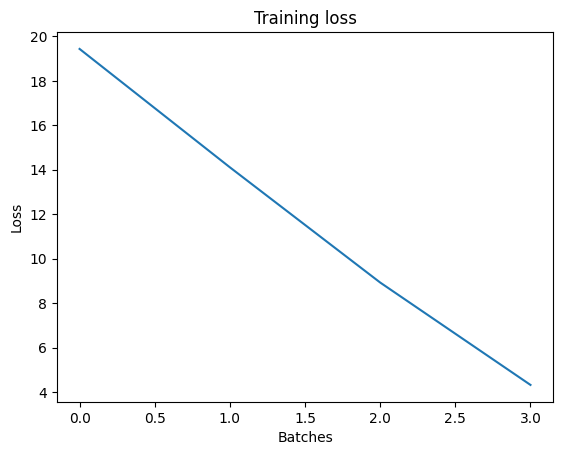

  0%|          | 0/3 [00:00<?, ?it/s]

TypeError: sequence item 50: expected str instance, NoneType found

In [40]:
gptTrainer.train(1)

In [ ]:
print(gptTrainer.model.generate('Что такое питон?'))

In [ ]:
for el in gptTrainer.data[0][0]['generated']:
    print(el[1])
    break

In [ ]:
GPTparams = {
    'batch_size': [10, 20],
    'lr': [1e-5, 1e-6, 1e-4],
    'ngrams': [1, 2, 3, 4, 5]
}

In [ ]:
gptTrainer.choose_model(GPTparams)